In [39]:
import pandas as pd
import datetime, pytz
import IPython
import matplotlib.pyplot as plt
import tinkoff.invest

import tradeBot

In [40]:
bot = tradeBot.TradeBot(False)

Loading trained models..
Done loading trained models
############
Today is 2024-05-13


In [41]:
histories = bot.getOperationHistory()

In [42]:
IMOEX = "BBG00KDWPPW2"
IMOEX = "BBG333333333"
imoexDayResults = {}
with tinkoff.invest.Client(bot.token, target=tinkoff.invest.constants.INVEST_GRPC_API_SANDBOX) as client:
  candles = client.get_all_candles(instrument_id = IMOEX,
      from_ = datetime.datetime.utcnow().replace(tzinfo=pytz.timezone('UTC')) - datetime.timedelta(days=120),
      interval = tinkoff.invest.CandleInterval.CANDLE_INTERVAL_DAY,
      candle_source_type = tinkoff.invest.schemas.CandleSource.CANDLE_SOURCE_UNSPECIFIED)
  for candle in candles:
    o = candle.open.units + candle.open.nano * 10**(-9)
    c = candle.close.units + candle.close.nano * 10**(-9)
    imoexDayResults[candle.time.date()] = c / o

In [43]:
def displayStatsForHistory(history, imoexDayResults):
  columns = ["ticker", "day", "moneySpent", "moneyRecieved", "outcome"]
  colData = {}
  days = {}
  lastDay = None
  accountNum = 0
  bank = history["totalMoney"]
  bankHistory = [bank]
  refBank = bank
  refHistory = [bank]

  for i in range(len(history["actions"])):
    day = history["actions"][i]["day"]
    if not day in days:
      days[day] = 0
      if lastDay is not None:
        change = days[lastDay]
        days[lastDay] = change / bank
        bank += change
        bankHistory.append(bank)
        refBank *= imoexDayResults[day]
        refHistory.append(refBank)
      lastDay = day
    if "moneyRecieved" in history["actions"][i]:
      days[day] += history["actions"][i]["moneyRecieved"] - history["actions"][i]["moneySpent"]
    for col in columns:
      colData.setdefault(col, [])
      if col in history["actions"][i]:
        colData[col].append(history["actions"][i][col])
      else:
        colData[col].append(0)

  df = pd.DataFrame(colData, columns = columns)
  df["moneyChange"] = df["moneyRecieved"] - df["moneySpent"]
  for day in days:
    dfDay = df[df["day"] == day]
    IPython.display.display(dfDay.style.set_caption("<b>" + str(day) + " {:+.2f}%".format(100*days[day]) + "</b>"))
    print()
  plt.figure()
  plt.grid()
  plt.plot(list(days.keys()), bankHistory, label="Trading")
  plt.plot(list(days.keys()), refHistory, label="IMOEX")
  plt.legend()
  plt.xticks(rotation=90);

,ticker,day,moneySpent,moneyRecieved,outcome,moneyChange
0,LSRG,2024-05-02,195156.000000,189150.000000,-0.030775,-6006.000000
1,ZILLP,2024-05-02,197748.000000,187974.540000,-0.049424,-9773.460000
2,NOMPP,2024-05-02,212706.000000,202652.460000,-0.047265,-10053.540000
3,SFIN,2024-05-02,202844.400000,206375.000000,0.017405,3530.600000
4,SFIN,2024-05-02,81850.000000,81520.000000,-0.004032,-330.000000
5,SFIN,2024-05-02,81550.000000,81410.000000,-0.001717,-140.000000
6,SFIN,2024-05-02,81080.000000,81210.000000,0.001603,130.000000


,ticker,day,moneySpent,moneyRecieved,outcome,moneyChange
7,GTRK,2024-05-03,156736.000000,165664.000000,0.056962,8928.000000
8,ZILLP,2024-05-03,157372.740000,147630.000000,-0.061909,-9742.740000
9,HHRU,2024-05-03,156480.000000,164256.000000,0.049693,7776.000000
10,TGKB,2024-05-03,147785.000000,147345.000000,-0.002977,-440.000000
11,GRNT,2024-05-03,160257.942000,158340.325600,-0.011966,-1917.616400
12,IRKT,2024-05-03,154000.000000,152790.000000,-0.007857,-1210.000000


,ticker,day,moneySpent,moneyRecieved,outcome,moneyChange
13,MRKU,2024-05-06,153594.000000,154652.000000,0.006888,1058.000000
14,ZILLP,2024-05-06,156998.000000,152812.460000,-0.026660,-4185.540000


,ticker,day,moneySpent,moneyRecieved,outcome,moneyChange
15,GRNT,2024-05-07,636825.564000,636235.910700,-0.000926,-589.653300
16,GTRK,2024-05-07,648384.000000,649572.000000,0.001832,1188.000000


,ticker,day,moneySpent,moneyRecieved,outcome,moneyChange
17,ZILLP,2024-05-08,647954.180000,611100.000000,-0.056878,-36854.180000
18,GRNT,2024-05-08,651353.670000,635365.898100,-0.024545,-15987.771900
19,VRSB,2024-05-08,642200.000000,635550.000000,-0.010355,-6650.000000


,ticker,day,moneySpent,moneyRecieved,outcome,moneyChange
20,QIWI,2024-05-10,628767.600000,614837.200000,-0.022155,-13930.400000
21,MRKV,2024-05-10,622566.000000,623420.000000,0.001372,854.000000


,ticker,day,moneySpent,moneyRecieved,outcome,moneyChange
22,QIWI,2024-05-13,1277463.600000,1329711.600000,0.040900,52248.000000
23,PMSBP,2024-05-13,1276308.000000,1220406.000000,-0.043800,-55902.000000
24,ORUP,2024-05-13,1282355.484000,1307178.675000,0.019357,24823.191000


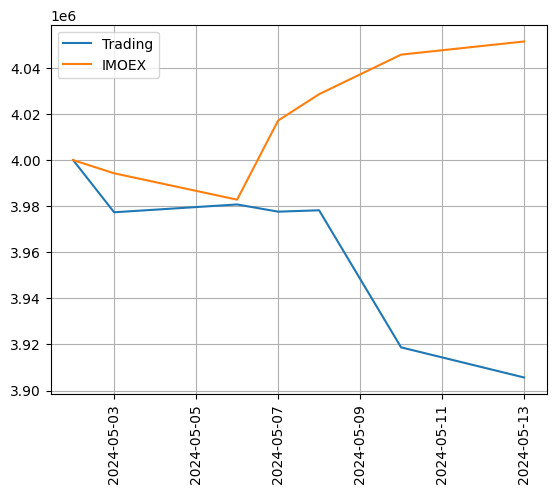

In [44]:
displayStatsForHistory(histories[0], imoexDayResults)

,ticker,day,moneySpent,moneyRecieved,outcome,moneyChange
0,SFIN,2024-05-02,202844.400000,198374.000000,-0.022039,-4470.400000
1,LSRG,2024-05-02,194961.000000,189189.000000,-0.029606,-5772.000000
2,ZILLP,2024-05-02,197748.000000,204660.000000,0.034954,6912.000000
3,NOMPP,2024-05-02,212706.000000,202652.460000,-0.047265,-10053.540000
4,ZILLP,2024-05-02,79590.000000,79275.000000,-0.003958,-315.000000


,ticker,day,moneySpent,moneyRecieved,outcome,moneyChange
5,GTRK,2024-05-03,156736.000000,159774.000000,0.019383,3038.000000
6,ZILLP,2024-05-03,161119.710000,151145.000000,-0.061909,-9974.710000
7,LSRG,2024-05-03,161515.200000,158390.400000,-0.019347,-3124.800000
8,TGKB,2024-05-03,161220.000000,160740.000000,-0.002977,-480.000000
9,GRNT,2024-05-03,161752.266000,159816.768800,-0.011966,-1935.497200
10,IRKT,2024-05-03,161000.000000,159735.000000,-0.007857,-1265.000000


,ticker,day,moneySpent,moneyRecieved,outcome,moneyChange
11,GTRK,2024-05-06,151320.000000,147150.000000,-0.027557,-4170.000000
12,ZILLP,2024-05-06,153585.000000,149490.450000,-0.026660,-4094.550000
13,TGKBP,2024-05-06,158530.000000,159443.000000,0.005759,913.000000


,ticker,day,moneySpent,moneyRecieved,outcome,moneyChange
14,GTRK,2024-05-07,643472.000000,644651.000000,0.001832,1179.000000
15,GRNT,2024-05-07,632818.764000,632232.820700,-0.000926,-585.943300


,ticker,day,moneySpent,moneyRecieved,outcome,moneyChange
16,QIWI,2024-05-08,643052.800000,606850.400000,-0.056298,-36202.400000
17,GRNT,2024-05-08,647255.290000,631368.114700,-0.024545,-15887.175300
18,ZILLP,2024-05-08,644614.210000,607950.000000,-0.056878,-36664.210000


,ticker,day,moneySpent,moneyRecieved,outcome,moneyChange
19,QIWI,2024-05-10,615064.200000,601437.400000,-0.022155,-13626.800000
20,VRSB,2024-05-10,614730.000000,611010.000000,-0.006051,-3720.000000


,ticker,day,moneySpent,moneyRecieved,outcome,moneyChange
21,QIWI,2024-05-13,1262402.400000,1314034.400000,0.040900,51632.000000
22,PMSBP,2024-05-13,1262244.000000,1206958.000000,-0.043800,-55286.000000
23,ORUP,2024-05-13,1267255.752000,1263602.214000,-0.002883,-3653.538000


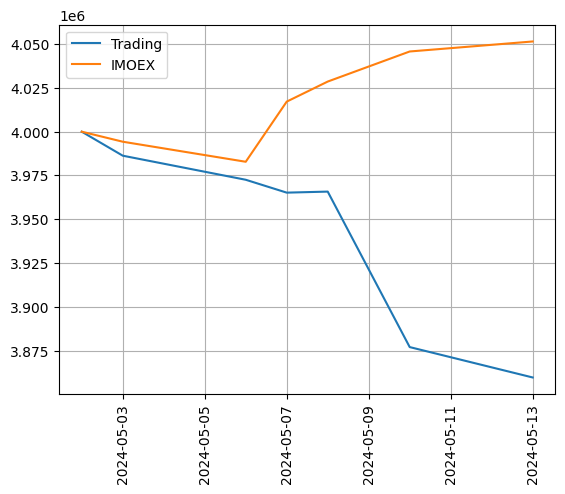

In [45]:
displayStatsForHistory(histories[1], imoexDayResults)